In [1]:
# basic set up
import numpy as np
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from shapely.geometry import Point
from matplotlib.path import Path

# debug
import pdb


In [2]:
# TODO: read targets are possibly not needed to prepare the pointing centers
def read_targets(data_dir, prefix, fmt='fits'):
    '''
    Read the targets data from the file.
    '''
    if prefix is None:
        raise ValueError('Give prefix (cos, sky, or star) of data file!')

    # Read the data table
    data_fn = data_dir + prefix + '_targets.' + fmt
    if fmt == 'fits':
        data_table = Table.read(data_fn, format='fits')
    elif fmt == 'ecsv':
        data_table = Table.read(data_fn, format='ascii.ecsv')
    else:
        raise ValueError('The format is not supported!')

    return data_table



# TODO: needs to be revised once the tiling strategy is finalized    
def predefine_pointing_centers(ra_min, ra_max, dec_min, dec_max, xscale=1., yscale=1., diameter=1.38):
    '''determine the pointing centers of PFS polygons, assuming no overlapping of polygons
    
    NOTE (need revision)
    ==========
    here we assume flat sky, i.e. the curvature of the sky is neglected.
    
    Parameters
    ==========
    ra_min, ra_max, dec_min, dec_max : float
        ra, dec range of the region
    diameter: float, in. deg
        PFS FoV diameter
    xscale, yscale: float
        (0.5, 1], 1 means no overlapping and <1 means overlapping
        
    Returns
    =======
    numpy array of pointing centers
    '''
    #initialize the first pointing 
    side = diameter/2. 
    height = np.sqrt(3.)/2.*side 
    
    #no overlapping of hexagons, i.e. max dist 
    xdist0 = 2*height
    ydist0 = (3./2.*side) 
    
    xdist = xdist0*xscale
    ydist = ydist0*yscale
    
    np_ra = int((ra_max - ra_min)/xdist) + 2
    np_dec = int((dec_max - dec_min)/ydist) + 2
    
    peak = []
    #initialize the first two pointing centers
    peak_x0, peak_y0 = [ra_min, ra_min+xdist/2.], dec_min+ydist/2.
    for i in range(np_dec):
        peak_y = peak_y0 + i*ydist
        for j in range(np_ra):
            peak_x = peak_x0[i%2] + j*xdist
            peak.append([peak_x, peak_y])
    
    return np.array(peak)

def save_pointings(peak, filename, fmt='ascii'):
    '''save the pointing centers to a file
    
    Parameters
    ==========
    peak: list
        list of pointing centers
    filename: string
        name of the file
    '''
    with open(filename, 'w') as f:
        f.write('# ra_pointing dec_pointing\n')
        for p in peak:
            f.write('%.6f %.6f\n' % (p[0], p[1]))

    print('Pointing centers are saved to %s' % filename)


def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

Time for reading the scientific targets: 1.763 sec.
-30.512<ra<40.189, -7.246<dec<6.539.
There are 7152462 scientific targets.
There are 915 pointings.
Time for getting the pointing centers: 0.382 sec.
  Your sample (gray), with the pointings (red):


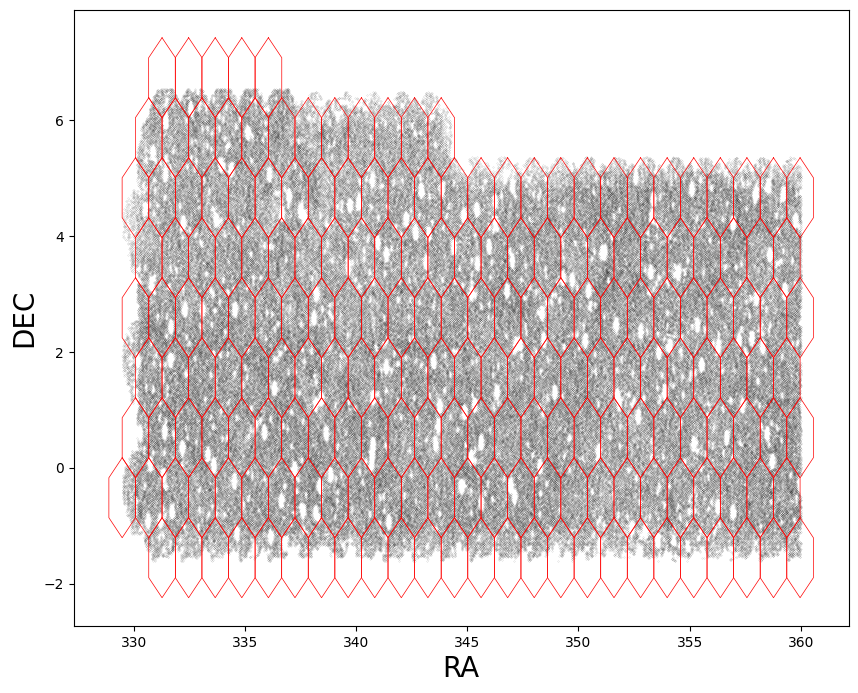

Time for plotting the pointings: 65.092 sec.
Pointing centers are saved to ../output/cosmology_region3_pointings.txt


In [4]:
# TODO: take care of the 360 and 0 deg issuse
if __name__ == "__main__":
    # TODO: revise the xscale and yscale for the final realistic tiling strategy
    xscale = 1. # 0-1., 1. is minimum/no overlapping 
    yscale = 1. # 0-1., 1. is minimum/no overlapping
    
    t0 = time.time()

    # read the scientific targets
    data_dir = '../data_proc/'
    prefix = 'cosmology_region3'
    cos_data_table = read_targets(data_dir, prefix, fmt='fits')

    raCos = cos_data_table['R.A.']
    decCos = cos_data_table['Dec.']
    nCos = len(raCos)

    # wrap the ra to [-180, 180]
    raCos[raCos>300] -= 360

    t1 = time.time()
    print("Time for reading the scientific targets: %.3f sec." % (t1-t0))
    
    # quick statistics + set the range for getting pointing centers
    ra_min, ra_max, dec_min, dec_max = raCos.min(), raCos.max(), decCos.min(), decCos.max()
    print("%.3f<ra<%.3f, %.3f<dec<%.3f." % (ra_min, ra_max, dec_min, dec_max))
    print("There are %d scientific targets." % nCos)
    #ra_min, ra_max, dec_min, dec_max = 80.6, 81.6, 0.5, 1.5

    # get the pointing centers
    peaks = predefine_pointing_centers(ra_min, ra_max, dec_min, dec_max, xscale, yscale)
    print("There are %d pointings." % len(peaks))

    # wrap the ra to [0, 360]
    peaks_ra = peaks[:, 0]
    peaks[:, 0][peaks_ra<0] += 360.
    raCos[raCos<0] += 360.  

    t2 = time.time()        
    print("Time for getting the pointing centers: %.3f sec." % (t2-t1))
    
    # plot the pointing and samples (filter out the fov w/o enough scientific targets)
    # plot for a small region
    mask_cos = (raCos>300) 
    mask_peak_ra = (peaks[:, 0]>300)

    plt.figure(figsize=(10, 8))
    print("  Your sample (gray), with the pointings (red):")
    plt.plot(raCos[mask_cos][::10], decCos[mask_cos][::10], 'k.', ms=0.2, alpha=0.5)

    mask_peaks_reserved = []
    for peak in peaks[mask_peak_ra]:
        flag_reserved = plot_filter_fov(peak[0], peak[1], raCos[mask_cos], decCos[mask_cos], filter_fov=True)
        mask_peaks_reserved.append(flag_reserved)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig('../output/figures/%s_fov_plot.png'%(prefix))
    plt.show()
    plt.close()

    t3 = time.time()
    print("Time for plotting the pointings: %.3f sec." % (t3-t2))

    # save the pointing centers to ascii file
    # TODO: save the reserved pointings of the whole region, not the region masked by mask_peak_ra
    out_dir = '../output/'
    save_pointings(peaks[mask_peak_ra][mask_peaks_reserved], out_dir+'%s_pointings.txt'% prefix)